# Predicting avalanche problems based on meteorological data alone

We use the regional meteorological statisteics from APS to predict the most important avalanche problem for the given day and region.
The target variable is avalanche_problem_1_problem_type_id, which can have the following values:



| Value | Description|
|----|---|
| 0  | Ikke gitt|
| 3  | Loose dry avalanches|
| 5  | Loose wet avalanches|
| 7  | New snow slab|
| 10 |  Wind slab|
| 20 | New snow|
| 30 | Persistent slab|
| 37 | Persistent deep slab|
| 40 | Wet snow|
| 45 | Wet slab|
| 50 | Glide avalanche|

In order to get continous values we re-grouped it in the variable avalanche_problem_1_problem_type_id_class, which can have the following values:

| Value | Description|
|----|---|
| 0 | Not given |
| 1 | Loose dry |
| 2 | Loose wet |
| 3 | Glide avalanche |
| 4 | Wet slab |
| 5 | Storm slab |
| 6 | Wind slab |
| 7 | Persistent slab |

In [1]:
import pandas as pd
import numpy as np
import json
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import train_test_split

sns.set(style="white")
pd.set_option("display.max_rows",6)

%matplotlib inline

C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df_data = pd.read_csv('varsom_ml_preproc.csv', index_col=0)

#[print(f'\'{c}\', ') for c in df_data.columns]

In [3]:
av_prob_1_properties = [
    'avalanche_problem_1_cause_id', 
    'avalanche_problem_1_destructive_size_ext_id', 
    'avalanche_problem_1_distribution_id', 
    'avalanche_problem_1_exposed_height_1', 
    'avalanche_problem_1_exposed_height_2', 
    'avalanche_problem_1_ext_id', 
    'avalanche_problem_1_probability_id', 
    'avalanche_problem_1_problem_id', 
    'avalanche_problem_1_problem_type_id', 
    'avalanche_problem_1_trigger_simple_id_class', 
    'avalanche_problem_1_type_id',
    'avalanche_problem_1_problem_type_id_class'
]

av_prob1_df = df_data.filter(av_prob_1_properties, axis=1)
for col in av_prob1_df.columns.values:
    print(f'{col}: {av_prob1_df[col].unique()} \n')

avalanche_problem_1_cause_id: [15 10 19 11 22 18 16 20 14 24 13  0] 

avalanche_problem_1_destructive_size_ext_id: [2 1 3 0 4] 

avalanche_problem_1_distribution_id: [1 2 3 0] 

avalanche_problem_1_exposed_height_1: [   0  400  700  800  600 1000  500 1200  300  200  900 1100 1400 1300
 1500  100 2000 1900 1700 1600 2100] 

avalanche_problem_1_exposed_height_2: [   0  400 1400  200  500  700  100 1000  800  300  600  900 1100 2000
 1200 1900] 

avalanche_problem_1_ext_id: [20 25  0 10 15] 

avalanche_problem_1_probability_id: [3 5 2 0] 

avalanche_problem_1_problem_id: [1 0] 

avalanche_problem_1_problem_type_id: [10 30  7 45 37  0 50  3  5] 

avalanche_problem_1_trigger_simple_id_class: [1 2 3 0] 

avalanche_problem_1_type_id: [10  0 20] 

avalanche_problem_1_problem_type_id_class: [6 7 5 4 0 3 1 2] 



In [4]:
target_ = ['avalanche_problem_1_problem_type_id_class']
target_classes = {
    "0": "Not given",
    "1": "Loose dry",
    "2": "Loose wet",
    "3": "Glide avalanche",
    "4": "Wet slab",
    "5": "Storm slab",
    "6": "Wind slab",
    "7": "Persistent slab"
    }
features_ = [
    #'mountain_weather_freezing_level', # correlates with min/max temperature
    'mountain_weather_precip_most_exposed', 
    'mountain_weather_precip_most_exposed_yesterday',
    'mountain_weather_precip_region', 
    'mountain_weather_precip_region_yesterday', 
    'mountain_weather_temperature_elevation', 
    'mountain_weather_temperature_max', 
    'mountain_weather_temperature_min', 
    'mountain_weather_wind_speed_num', 
    #'mountain_weather_wind_direction_num', 
    'mountain_weather_wind_direction_E', 
    'mountain_weather_wind_direction_N', 
    'mountain_weather_wind_direction_NE', 
    'mountain_weather_wind_direction_NW', 
    'mountain_weather_wind_direction_None', 
    'mountain_weather_wind_direction_S', 
    'mountain_weather_wind_direction_SE', 
    'mountain_weather_wind_direction_SW', 
    'mountain_weather_wind_direction_W',
    #'region_id',  # correlates with region_group_id
    'region_group_id'
    #'region_type_id'  # currently only A in the dataset
    ]
X = df_data.filter(features_, axis=1)
y = df_data.filter(target_, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 222, test_size = 0.3)

C:\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0,'Not given'),
 Text(0,0,'Loose dry'),
 Text(0,0,'Loose wet'),
 Text(0,0,'Glide avalanche'),
 Text(0,0,'Wet slab'),
 Text(0,0,'Storm slab'),
 Text(0,0,'Wind slab'),
 Text(0,0,'Persistent slab')]

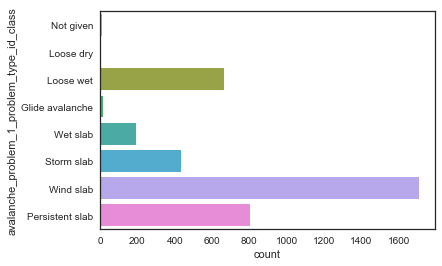

In [5]:
ax = sns.countplot(y='avalanche_problem_1_problem_type_id_class', data=av_prob1_df)
ax.set_yticklabels(target_classes.values())

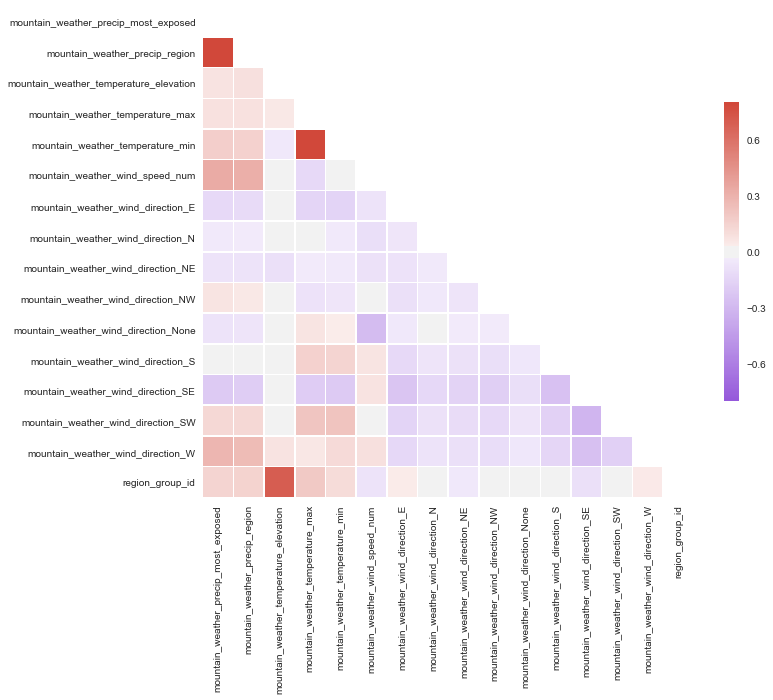

In [6]:
# Compute the correlation matrix - works only on numerical variables.
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(1000, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

(1147,) (1147, 1)
Decision tree R^2: 0.5981


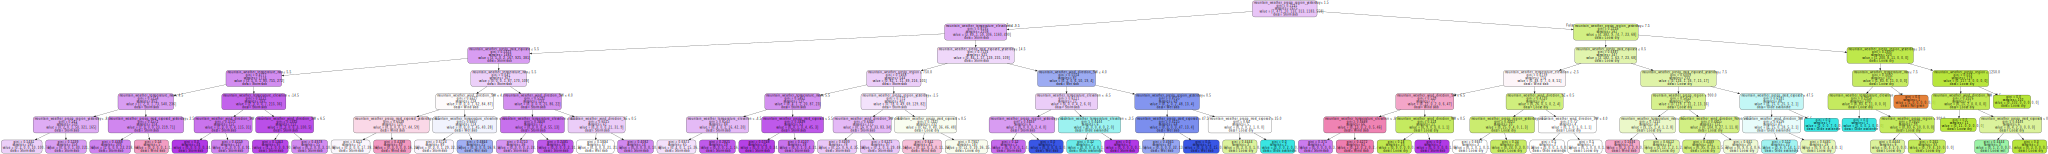

In [7]:
dec_tree = tree.DecisionTreeClassifier(random_state=222, max_depth = 6)

dec_tree.fit(X_train, y_train) # we're using the same data as in last linear model

predictions_dt = dec_tree.predict(X_test)
print(predictions_dt.shape, y_test.shape)

print('Decision tree R^2: %.4f' % dec_tree.score(X_test, y_test)) 


# Visualize the tree
dot_data = tree.export_graphviz(dec_tree, out_file=None,  #'tree.dot', 
                         feature_names=features_,
                         class_names=list(target_classes.values()),  # seems like they are in the wrong order...
                         filled=True, rounded=True, #rotate=True,  
                         special_characters=True)  

graph = graphviz.Source(dot_data)  
graph 

Text(0,0.5,'$R^2$')

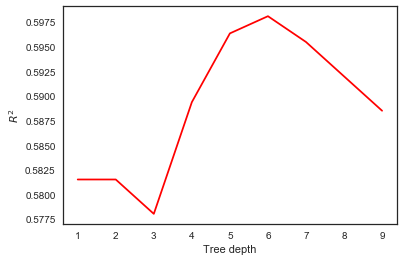

In [8]:
depths = range(1, 10)

tree_models = [tree.DecisionTreeClassifier(random_state=222, max_depth=d).fit(X_train, y_train) for d in depths]
tree_Rsquare = [f.score(X_test, y_test) for f in tree_models]

plt.plot(depths, tree_Rsquare, color = 'red')
plt.xlabel('Tree depth')
plt.ylabel('$R^2$')

In [9]:
print(y_train.values.shape)

(2675, 1)


In [10]:
grad_boost = ensemble.GradientBoostingClassifier(random_state = 12, max_depth = 6)

grad_boost.fit(X_train, y_train.values.flatten())

predictions_gb = grad_boost.predict(X_test)

print('Gradient boosted tree R^2: %.4f' % grad_boost.score(X_test, y_test)) 

Gradient boosted tree R^2: 0.6478


In [11]:
importance = grad_boost.feature_importances_
feature_indexes_by_importance = importance.argsort()
for index in feature_indexes_by_importance:
    print(f'{features_[index]}: \t{(importance[index] *100.0):.2f}%')

mountain_weather_wind_direction_NE: 	0.29%
mountain_weather_wind_speed_num: 	0.68%
mountain_weather_wind_direction_N: 	0.95%
mountain_weather_wind_direction_E: 	1.05%
mountain_weather_temperature_min: 	1.10%
mountain_weather_wind_direction_SE: 	1.64%
mountain_weather_wind_direction_S: 	1.80%
mountain_weather_wind_direction_NW: 	2.03%
mountain_weather_wind_direction_None: 	2.49%
mountain_weather_precip_region: 	5.09%
mountain_weather_precip_most_exposed_yesterday: 	7.23%
mountain_weather_temperature_max: 	9.49%
mountain_weather_wind_direction_SW: 	12.91%
mountain_weather_precip_most_exposed: 	13.70%
mountain_weather_precip_region_yesterday: 	17.35%
mountain_weather_temperature_elevation: 	20.93%


## Predicting detailed avalanche problem

We merge the attributes of the first avalanche problem into a single parameter, which the classifier should predict.

We use the following attributes:
- avalanche_problem_1_problem_type_id_class: [1 2 3 4 5 6 0] 
- avalanche_problem_1_distribution_id: [1 2 3 0] 
- avalanche_problem_1_sensitivity_id_class: [1 2 3 4 5 6 0] 
- avalanche_problem_1_destructive_size_ext_id: [1 2 3 4 0] 

The combined attribute consists of the ID values of each attribute in the order: problem_type - distribution - trigger - size.
E.g. Wind slabs on specific slopes, easy to trigger, size 2 would correspond to _6222_.


In [12]:
df_data['aval_problem_1_combined']

index
0       6112
1       6222
2       6222
        ... 
3819    2121
3820    2121
3821    2121
Name: aval_problem_1_combined, Length: 3822, dtype: int64

In [13]:
target_ = ['aval_problem_1_combined']

features_ = [
    #'mountain_weather_freezing_level', # correlates with min/max temperature
    'mountain_weather_precip_most_exposed',
    'mountain_weather_precip_most_exposed_yesterday',
    'mountain_weather_precip_region', 
    'mountain_weather_precip_region_yesterday', 
    'mountain_weather_temperature_elevation', 
    'mountain_weather_temperature_max', 
    'mountain_weather_temperature_min', 
    'mountain_weather_wind_speed_num', 
    #'mountain_weather_wind_direction_num', 
    'mountain_weather_wind_direction_E', 
    'mountain_weather_wind_direction_N', 
    'mountain_weather_wind_direction_NE', 
    'mountain_weather_wind_direction_NW', 
    'mountain_weather_wind_direction_None', 
    'mountain_weather_wind_direction_S', 
    'mountain_weather_wind_direction_SE', 
    'mountain_weather_wind_direction_SW', 
    'mountain_weather_wind_direction_W',
    #'region_id',  # correlates with region_group_id
    'region_group_id'
    #'region_type_id'  # currently only A in the dataset
    ]
X = df_data.filter(features_, axis=1)
y = df_data.filter(target_, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 222, test_size = 0.3)

Wall time: 296 ms


Text(0,0.5,'$R^2$')

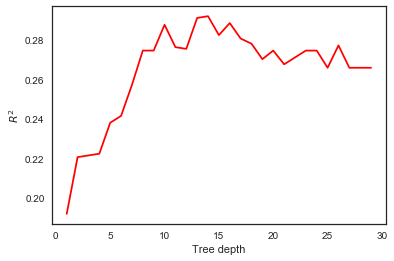

In [14]:
depths = range(1, 30)

%time tree_models = [tree.DecisionTreeClassifier(random_state=222, max_depth=d).fit(X_train, y_train) for d in depths]
tree_Rsquare = [f.score(X_test, y_test) for f in tree_models]

plt.plot(depths, tree_Rsquare, color = 'red')
plt.xlabel('Tree depth')
plt.ylabel('$R^2$')

In [15]:
dec_tree = tree.DecisionTreeClassifier(random_state=222, max_depth = 6)

dec_tree.fit(X_train, y_train) # we're using the same data as in last linear model

predictions_dt = dec_tree.predict(X_test)
print(predictions_dt.shape, y_test.shape)

print('Decision tree R^2: %.4f' % dec_tree.score(X_test, y_test)) 


# Visualize the tree
dot_data = tree.export_graphviz(dec_tree, out_file=None,  #'tree.dot', 
                         feature_names=features_,
                         #class_names=list(target_classes.values()),
                         filled=True, rounded=True, #rotate=True,  
                         special_characters=True)  

graph = graphviz.Source(dot_data)  
#graph.render('aval_problem_combined_dt')

(1147,) (1147, 1)
Decision tree R^2: 0.2415


In [16]:
grad_boost = ensemble.GradientBoostingClassifier(random_state = 12, max_depth = 6)

grad_boost.fit(X_train, y_train.values.flatten())

predictions_gb = grad_boost.predict(X_test)

print('Gradient boosted tree R^2: %.4f' % grad_boost.score(X_test, y_test)) 

Gradient boosted tree R^2: 0.2772


In [17]:
importance = grad_boost.feature_importances_
feature_indexes_by_importance = importance.argsort()
for index in feature_indexes_by_importance:
    print(f'{features_[index]}: \t{(importance[index] *100.0):.2f}%')

mountain_weather_wind_speed_num: 	0.19%
mountain_weather_wind_direction_NE: 	0.23%
mountain_weather_wind_direction_N: 	0.38%
mountain_weather_wind_direction_E: 	0.56%
mountain_weather_wind_direction_NW: 	0.80%
mountain_weather_wind_direction_SE: 	0.90%
mountain_weather_temperature_min: 	1.32%
mountain_weather_wind_direction_S: 	1.69%
mountain_weather_wind_direction_None: 	3.21%
mountain_weather_precip_region: 	4.55%
mountain_weather_precip_most_exposed_yesterday: 	5.31%
mountain_weather_temperature_max: 	6.77%
mountain_weather_wind_direction_SW: 	8.01%
mountain_weather_precip_most_exposed: 	8.22%
mountain_weather_temperature_elevation: 	12.70%
mountain_weather_precip_region_yesterday: 	13.81%
